In [1]:
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal, stats
from scipy.ndimage import center_of_mass

# install moonbow first. in repo root:
# pip install -e . --no-deps
from moonbow.fit import Fit

rng = np.random.default_rng()

In [2]:
# support functions for our model
def recenter_x(x, convolved, pdf0, pdf1):
    com = center_of_mass(
        convolved
    )[0] / len(x) * np.ptp(x) + x.min()
    ocom = center_of_mass(
        pdf0 + pdf1
    )[0] / len(x) * np.ptp(x) + x.min()
    return np.linspace(
        x.min(), x.max(), len(convolved)
    ) + ocom + (ocom - com)

def convolve_pdfs(x, pdf0, pdf1):
    convolved = signal.fftconvolve(pdf0, pdf1, "same")
    recentered_x = recenter_x(x, convolved, pdf0, pdf1)
    return recentered_x, convolved

# this is the function we will use as a model for our data. the first parameter
# is an "independent variable" of arbitrary dimensionality. the next are
# mathematical parameters of the model that we can vary to best fit our data.
# the function must return a 1-dimensional numpy array.
def normal_gamma_model(
    data_range, 
    gamma_shape, 
    gamma_scale, 
    norm_loc, 
    norm_scale, 
    model_range
):
    gamma_pdf = stats.gamma.pdf(
        model_range, gamma_shape, scale=gamma_scale
    )
    normal_pdf = stats.norm.pdf(
        model_range, loc=norm_loc, scale=norm_scale
    )
    cx, cy = convolve_pdfs(model_range, gamma_pdf, normal_pdf)
    interp = np.interp(data_range, cx, cy)
    return interp / interp.sum()

In [3]:
def logistic_normal_model(
    data_range, 
    log_loc, 
    log_scale, 
    norm_loc, 
    norm_scale, 
    model_range
):
    log_pdf = stats.logistic.pdf(
        model_range, loc=log_loc, scale=log_scale
    )
    normal_pdf = stats.norm.pdf(
        model_range, loc=norm_loc, scale=norm_scale
    )
    cx, cy = convolve_pdfs(model_range, log_pdf, normal_pdf)
    interp = np.interp(data_range, cx, cy)
    return interp / interp.sum()

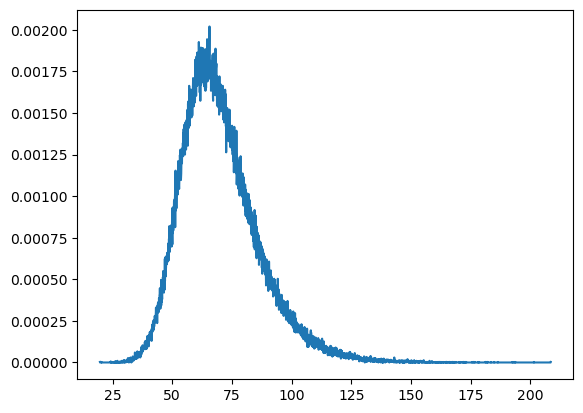

In [4]:
# create some sample data
size = 300000
bin_scale = 100
n_bins = int(size / bin_scale)
random_variates = (
   rng.normal(loc=50, scale=8, size=size)
   + rng.gamma(shape=2, scale=10, size=size)
)
counts, edges = np.histogram(random_variates, n_bins)
x = (edges[:-1] + edges[1:]) / 2
y = counts / counts.sum()
# add some noise to the data
temperature = (
    2 - np.sin(np.linspace(-20, 3, n_bins))
) * 100
noise = np.random.uniform(
    0, 1, n_bins
) * y.max() / temperature.max() * temperature / 8
# y += noise
plt.plot(x, y)

In [5]:
# establish a model range -- necessary just because of the 
# model we're using. wouldn't have to do this for everything.
# other models might require other kinds of preprocessing.
model_range = np.linspace(-20, 120, size)
model = partial(normal_gamma_model, model_range=model_range)

In [6]:
# create a dataframe and initialize the Fit object using it and our model function
data = pd.DataFrame({'time': x, 'intensity': y, 'temp': temperature})
fitter = Fit(
    underlying_function=model,
    dimensionality=1,
    data=data,
    dependent_variable='intensity'
)

In [7]:
# produce a vector from the independent variable(s)
fitter.make_vector(independent_variables=['time'])
# fit the curve. sometimes you will need a guess for starting
# parameters.
fitter.fit(guess=np.array([2, 11, 40, 10]))
# coefficient of determination of fitted model
fitter.det

/Users/cm/mambaforge/envs/moonbow/lib/python3.11/site-packages/scipy/signal/_signaltools.py:509: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)
/Users/cm/mambaforge/envs/moonbow/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1534: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


0.9963248905729274

In [8]:
# parameters of fitted model & cov matrix
fit_params, covariance_matrix = fitter.curve_fit
fit_params

array([ 1.91615282, 10.2166956 , 50.44668153,  8.03596703])

In [9]:
# coefficient of determination of fitted model
fitter.det

0.9963248905729274

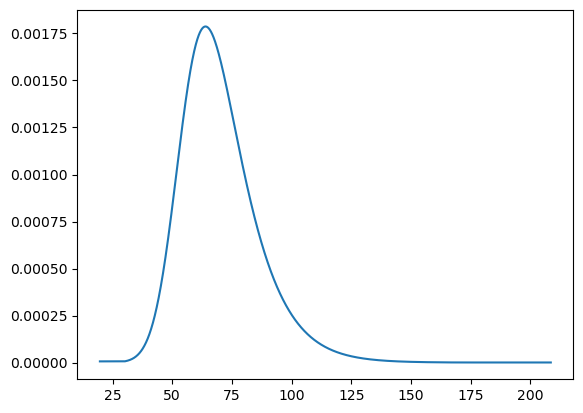

In [10]:
# fitted curve
plt.plot(x, fitter.fitted_curve)

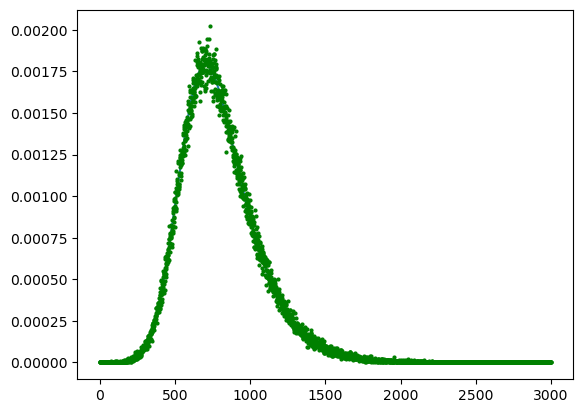

In [11]:
# convenience function to plot model residuals
fitter.plot_residuals()

In [12]:
# correlation matrix  --
# more interesting in a case with dimensionality > 1,
# but a strong correlation between detector temperature and 
# our model residuals is obvious.
fitter.correlations()

/Users/cm/mambaforge/envs/moonbow/lib/python3.11/site-packages/numpy/lib/function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


,res,|res|,time,intensity,temp
res,1.00,0.07,0.00,0.08,-0.01
|res|,0.07,1.00,-0.43,0.69,0.13
time,0.00,-0.43,1.00,-0.50,-0.07
intensity,0.08,0.69,-0.50,1.00,0.26
temp,-0.01,0.13,-0.07,0.26,1.00


TEST 1

In [15]:
def polynomial_model(data_range,c0,c1,c2,c3,c4):
    return c0 + c1 * x + c2 * x**2 + c3 * x**3 + c4 * x**4 

In [16]:
model = polynomial_model

In [17]:
# create a dataframe and initialize the Fit object using it and our model function
data = pd.DataFrame({'time': x, 'intensity': y, 'temp': temperature})
fitter = Fit(
    underlying_function=model,
    dimensionality=1,
    data=data,
    dependent_variable='intensity'
)

In [18]:
fitter.

In [19]:
# produce a vector from the independent variable(s)
fitter.make_vector(independent_variables=['time'])

[0        19.667331
 1        19.730308
 2        19.793284
 3        19.856261
 4        19.919238
            ...    
 2995    208.282322
 2996    208.345299
 2997    208.408275
 2998    208.471252
 2999    208.534229
 Name: time, Length: 3000, dtype: float64]

In [20]:
fitter.fit()

In [21]:
fitter.det

0.7463971363008004

In [22]:
fit_params, covariance_matrix = fitter.curve_fit
fit_params

array([-4.10043174e-03,  2.22133405e-04, -3.16247612e-06,  1.72656254e-08,
       -3.24580020e-11])

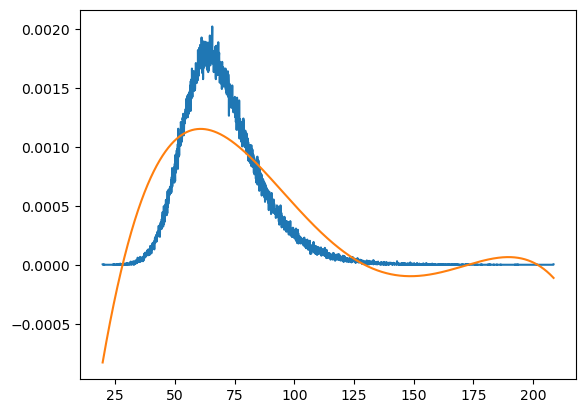

In [24]:
plt.plot(x, y)
plt.plot(x, fitter.fitted_curve)

TEST 2

In [27]:
def aflare1(t, tpeak, fwhm, ampl):
#    t : 1-d array
#        The time array to evaluate the flare over
#    tpeak : float
#        The time of the flare peak
#    fwhm : float
#        The "Full Width at Half Maximum", timescale of the flare
#   ampl : float
#        The amplitude of the flare
#    Returns
#    flare : 1-d array
#        The flux of the flare model evaluated at each time
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    
    t = np.array(t)
    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

In [29]:
model = aflare1

In [31]:
# create a dataframe and initialize the Fit object using it and our model function
data = pd.DataFrame({'time': x, 'intensity': y, 'temp': temperature})
fitter = Fit(
    underlying_function=model,
    dimensionality=1,
    data=data,
    dependent_variable='intensity'
)

In [33]:
fitter.make_vector(independent_variables=['time'])
fitter.fit()
fitter.det

/Users/cm/mambaforge/envs/moonbow/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

FIT 3

In [35]:
def aflare2(t, tpeak, fwhm, ampl,
            c0,c1,c2,c3,c4,
            d0,d1,d2,d3):
#    t : 1-d array
#        The time array to evaluate the flare over
#    tpeak : float
#        The time of the flare peak
#    fwhm : float
#        The "Full Width at Half Maximum", timescale of the flare
#   ampl : float
#        The amplitude of the flare
#    Returns
#    flare : 1-d array
#        The flux of the flare model evaluated at each time
    #_fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fr = [c0,c1,c2,c3,c4]
    #_fd = [0.689008, -1.60053, 0.302963, -0.278318]
    _fd = [d0,d1,d2,d3]
    
    t = np.array(t)
    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

In [36]:
#    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
#    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

In [37]:
model = aflare2

In [38]:
data = pd.DataFrame({'time': x, 'intensity': y, 'temp': temperature})
fitter = Fit(
    underlying_function=model,
    dimensionality=1,
    data=data,
    dependent_variable='intensity'
)

In [39]:
fitter.make_vector(independent_variables=['time'])
fitter.fit(guess=np.array([70,30,0.0020,
                          1.00000, 1.94053, -0.175084, -2.24588, -1.12498,
                          0.689008, -1.60053, 0.302963, -0.278318]))
fitter.det

0.9761061015433303

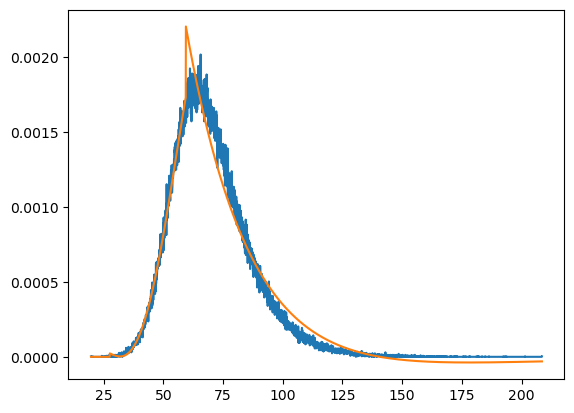

In [40]:
plt.plot(x,y)
plt.plot(x, fitter.fitted_curve)

In [43]:
fit_params, covariance_matrix = fitter.curve_fit
fit_params
#    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
#    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

array([ 5.93426048e+01,  3.18187900e+01,  2.04176775e-03,  8.49083464e-01,
        1.44566914e+00, -1.01796573e+00, -2.90823575e+00, -1.28252481e+00,
        1.57900048e+00, -1.09739980e+00, -4.95191078e-01, -6.43773023e-01])